# Project 3 Part 4
- Michael Vincent
- 10/5

## Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import glob
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Load the data

In [2]:
# Load the data using glob

# Get the filenames
q = 'Data/final_tmdb_data_*.csv.gz'
chunked_files = glob.glob(q)

# Load the files
df_list = []
for file in chunked_files:
    temp_df = pd.read_csv(file, engine = 'python')
    df_list.append(temp_df)

# Combine the files into one data frame    
df = pd.concat(df_list)
df.head()

# Save the combined data frame
df.to_csv('Data/tmdb_results_combined.csv.gz',
          compression = 'gzip')

In [3]:
# Get the columns of interest
df = df[['imdb_id', 'budget', 'revenue', 'certification']]

# Drop the first row
df.drop(0, inplace = True)
df.head()

,imdb_id,budget,revenue,certification
1,tt0062336,0.0,0.0,NaN
2,tt0805647,0.0,26900000.0,PG
3,tt0920462,0.0,106045.0,R
4,tt0926132,0.0,0.0,NaN
5,tt0983946,7000000.0,47078545.0,PG-13


In [4]:
# Drop the null values
df.dropna(inplace = True)
df.head()

,imdb_id,budget,revenue,certification
2,tt0805647,0.0,26900000.0,PG
3,tt0920462,0.0,106045.0,R
5,tt0983946,7000000.0,47078545.0,PG-13
6,tt10003008,0.0,4296804.0,R
9,tt10004108,0.0,0.0,R


In [5]:
# Check the values in the certification column
df['certification'].unique()

array(['PG', 'R', 'PG-13', 'NR', 'NC-17', 'G', 'Not Rated', 'UR',
       'Unrated', 'PG-13 ', '10', 'R ', 'ScreamFest Horror Film Festival',
       '-'], dtype=object)

> We see some ratings have an extra space.

In [6]:
# Get rid of the space in the ratings of R and PG-13. While it's not necessary
# for this project, we will replace 'UR' and 'Not Rated' with Unrated. 
df['certification'].replace({'PG-13 ': 'PG-13', 
                             'R ': 'R',
                             'UR': 'Unrated',
                             'Not Rated': 'Unrated'}, 
                            inplace = True)

# Make sure the changes were made
df['certification'].unique()

array(['PG', 'R', 'PG-13', 'NR', 'NC-17', 'G', 'Unrated', '10',
       'ScreamFest Horror Film Festival', '-'], dtype=object)

## Hypothesis Test: Do ratings have a significant effect on revenue?

**State the Null and Alternative Hypotheses**

$H_0$: The rating of a movie does not affect its revenue.

$H_1$: The rating of a movie has a significant effect on its revenue.

> We are comparing the mean revenue of more than two groups so we will use an ANOVA test.

In [7]:
# Get the revenues of the movies with ratings G, PG, PG-13, and R
g_movie_rev = df.loc[df['certification'] == 'G', 'revenue']
pg_movie_rev = df.loc[df['certification'] == 'PG', 'revenue']
pg13_movie_rev = df.loc[df['certification'] == 'PG-13', 'revenue']
r_movie_rev = df.loc[df['certification'] == 'R', 'revenue']

In [8]:
# Remove any outliers from the groups
g_movie_rev = g_movie_rev[abs(stats.zscore(g_movie_rev)) <= 3]
pg_movie_rev = pg_movie_rev[abs(stats.zscore(pg_movie_rev)) <= 3]
pg13_movie_rev = pg13_movie_rev[abs(stats.zscore(pg13_movie_rev)) <= 3]
r_movie_rev = r_movie_rev[abs(stats.zscore(r_movie_rev)) <= 3]
print(len(g_movie_rev),
      len(pg_movie_rev),
      len(pg13_movie_rev),
      len(r_movie_rev))

447 1451 3253 6244


> The sample sizes of each group are large enough that we may forgo the normality test

In [9]:
# Test the groups for equal variance
stats.levene(g_movie_rev,
             pg_movie_rev,
             pg13_movie_rev,
             r_movie_rev)

LeveneResult(statistic=258.1783756187162, pvalue=4.129948362335215e-162)

> The $p$-value is less than our $\alpha$ of 0.05 so we reject the null-hypothesis that the groups have the same variance and assume they do *not* have the same variance so we use the Kruskal-Wallis test.

In [10]:
# Perform the hypothesis test
stats.kruskal(g_movie_rev,
              pg_movie_rev,
              pg13_movie_rev,
              r_movie_rev)

KruskalResult(statistic=458.444710214375, pvalue=4.825294601401865e-99)

> Our $p$-value of $4.8 \times 10^{-99}$ is less than the given $\alpha$ of 0.05 so we reject the null hypothesis. That is, our data supports the claim that the rating of a film has a significant effect on its revenue.

In [11]:
# Perform a pairwise Tukey test

# Get a data frame with only g, pg, pg-13, and r ratings
filter = (df['certification'] == 'G') | (df['certification'] == 'PG') |\
(df['certification'] == 'PG-13') | (df['certification'] == 'R')
filtered_df = df.loc[filter, ['revenue', 'certification']]

# Set the values and labels
values = filtered_df['revenue']
labels = filtered_df['certification']

# Perform the test
results = pairwise_tukeyhsd(values, labels)
results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,33172285.8938,0.0,15247122.5829,51097449.2047,True
G,PG-13,38397468.8585,0.0,21676053.4135,55118884.3036,True
G,R,-18022092.9071,0.0226,-34258640.7753,-1785545.039,True
PG,PG-13,5225182.9647,0.5718,-5213973.3767,15664339.3062,False
PG,R,-51194378.8009,0.0,-60837808.5491,-41550949.0528,True
PG-13,R,-56419561.7657,0.0,-63581264.92,-49257858.6113,True


> We see from the above that the only ratings without a significant difference are PG and PG-13.

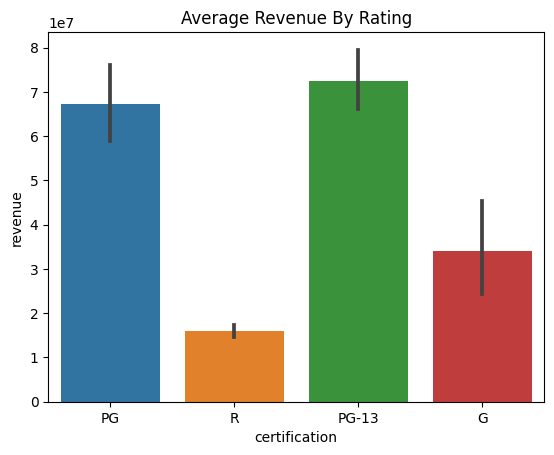

In [12]:
# Make a visualization illustrating the result.
sns.barplot(data = filtered_df, x = 'certification', y = 'revenue');
plt.title('Average Revenue By Rating');

> We see that movies with a rating of PG-13 have the most revenue, with the rating of PG coming in at a close second. We are surprised that R rated movies did so poorly. We understand that movies rated PG and PG-13 will reach a larger audience, but we still expected R rated movies to do better. Since we expect R rated movies to reach a larger audience than G rated movies, we would recommend a deeper dive into the data to see if there is something that we may be missing.

## Hypothesis Test: Do movies released in 2020 earn less revenue than movies released in 2018.

**Null and Alternative Hypotheses**

$H_0$: Movies released in 2020 earned the same revenue as movies released in 2018

$H_1$: There is a significant difference in revenue between movies released in 2020 than movies released in 2018.

> We are comparing the means of two groups so we will use a two-sample $t$-test.

In [13]:
# Load the data frame with the year information
basics = pd.read_csv('Data/title_basics.csv.gz')

# Join the two data frames
joined_data = basics.merge(df, left_on = 'tconst', right_on = 'imdb_id')
joined_data.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,imdb_id,budget,revenue,certification
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,NaN,118,"Comedy,Fantasy,Romance",tt0035423,48000000.0,76019048.0,PG-13
1,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,NaN,122,Drama,tt0069049,12000000.0,0.0,R
2,tt0116991,movie,Mariette in Ecstasy,Mariette in Ecstasy,0,2009,NaN,101,Drama,tt0116991,0.0,0.0,PG-13
3,tt0118141,movie,What Is It?,What Is It?,0,2005,NaN,72,Drama,tt0118141,0.0,0.0,NC-17
4,tt0118589,movie,Glitter,Glitter,0,2001,NaN,104,"Drama,Music,Romance",tt0118589,22000000.0,5271666.0,PG-13


In [14]:
# Get the two groups
movies_2020 = joined_data.loc[joined_data['startYear'] == 2020, 'revenue']
movies_2018 = joined_data.loc[joined_data['startYear'] == 2018, 'revenue']

In [15]:
# Remove any outliers
movies_2020 = movies_2020[abs(stats.zscore(movies_2020)) <= 3]
movies_2018 = movies_2018[abs(stats.zscore(movies_2018)) <= 3]

In [16]:
# Check the length of each group
print(len(movies_2020), len(movies_2018))

692 810


> The groups each have more than 15 data points so we can forgo the test for normality.

In [17]:
# Check for equal variance
stats.levene(movies_2020, movies_2018)

LeveneResult(statistic=34.73948448666277, pvalue=4.6470486065042775e-09)

> The $p$-value is less than our $\alpha$ of 0.05 so we reject the null hypothesis and assume the groups have different variances.

In [18]:
# Perform the hypothesis test
stats.ttest_ind(movies_2020, movies_2018, equal_var = False)

Ttest_indResult(statistic=-6.351619758556268, pvalue=3.4522036581056426e-10)

> Our $p$-value of $3.5 \times 10^{-10}$ is less than the given $\alpha$ of 0.05 so we reject the null hypothesis. That is, the data supports the claim that movies made in 2020 and 2018 have significantly different revenues.

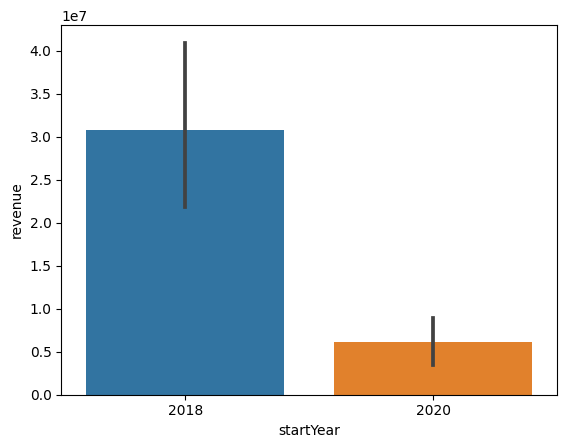

In [19]:
# Construct a visualization illustrating the result
viz_df = joined_data[(joined_data['startYear'] == 2020) |
                     (joined_data['startYear'] == 2018)]
sns.barplot(data = viz_df, x = 'startYear', y = 'revenue');

> The above graph shows movies made in 2018 had more revenue than movies made in 2020. (It is not difficult to guess why this might be the case.)

## Hypothesis Test: Do movies longer than 2.5 hours have a significant difference in revenue than movies less than 1.5 hours.

**Null and Alternative Hypotheses**

$H_0$: Movies longer than 2.5 hours and movies less than 1.5 hours earn the same amount of revenue.

$H_1$: Movies longer than 2.5 hours and movies less than 1.5 hours have a significant difference in revenue.

> We are comparing means of two groups so we use a 2-sample $t$-test.

In [20]:
# Get the two groups
long_movies = joined_data.loc[joined_data['runtimeMinutes'] > 150, 'revenue']
short_movies = joined_data.loc[joined_data['runtimeMinutes'] < 90, 'revenue']

In [21]:
# Remove any outliers
long_movies = long_movies[abs(stats.zscore(long_movies)) <= 3]
short_movies = short_movies[abs(stats.zscore(short_movies)) <= 3]

In [22]:
# Check the number of data points
print(len(long_movies), len(short_movies))

205 4256


> We have enough data points to skip the test for normality.

In [23]:
# Check for equal variance
stats.levene(long_movies, short_movies)

LeveneResult(statistic=1318.7138067595392, pvalue=3.448708224882196e-253)

> Our $p$-value is less than 0.05, so we do not have equal variance.

In [24]:
# Perform the hypothesis test
stats.ttest_ind(long_movies, short_movies)

Ttest_indResult(statistic=35.98299138326277, pvalue=3.6369639004870885e-249)

> Our $p$-value of $3.6 \times 10^{-249}$ is less than the given $\alpha$ of 0.05 so we reject the null hypothesis. That is, our data supports the claim that there is a significant difference in revenue for longer movies versus shorter movies.

In [25]:
# Make a data frame for a visualization.
def check_length(n):
    if n > 150:
        return 'long'
    if n < 90:
        return 'short'

viz_df = joined_data.copy()
viz_df['movie_length'] = viz_df['runtimeMinutes'].apply(check_length)

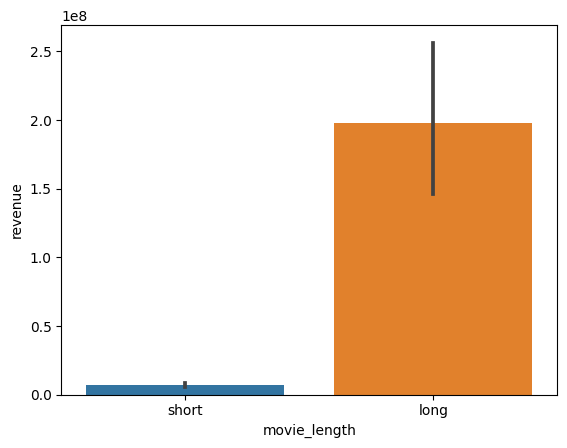

In [26]:
# Construct the visualization illustrating the result.
sns.barplot(data = viz_df, x = 'movie_length', y = 'revenue');

> We see that longer movies tend to earn more revenue than shorter movies.